In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb

In [3]:
items           = pd.read_csv('../items.csv')
item_categories = pd.read_csv('../item_categories.csv')
shops           = pd.read_csv('../shops.csv')
sales_train     = pd.read_csv('../sales_train_v2.csv')
test            = pd.read_csv('../test.csv')
sample_submission            = pd.read_csv('../sample_submission.csv')

In [282]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)


In [294]:
w_cat_ids = transactions.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids = w_cat_ids.reset_index()
w_cat_ids['row_id'] = w_cat_ids.index

w_cat_ids['item_shop_count_block'] = w_cat_ids.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].transform('sum').clip(0,20)

In [295]:
w_cat_ids['item_shop_count_block'] = w_cat_ids.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].transform('sum').clip(0,20)

In [296]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [297]:
global_mean = w_cat_ids.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().mean()
block_nums = w_cat_ids['date_block_num'].nunique()
number_of_shops =  w_cat_ids['shop_id'].nunique()

In [298]:
w_cat_ids['shop_global_mean'] = w_cat_ids.groupby(['shop_id'])['shop_id'].transform('nunique')

In [299]:
avg_items_ids_unique = w_cat_ids.groupby(['date_block_num', 'shop_id'])['item_id'].nunique().groupby(level=1).mean().reset_index(name='avg_items_ids_unique')
avg_items_ids_unique
w_cat_ids = pd.merge(w_cat_ids, pd.DataFrame(avg_items_ids_unique), on=['shop_id'], how='left')

In [300]:
w_cat_ids['number_shops_selling_item'] = w_cat_ids.groupby(['item_id'])['shop_id'].transform('nunique')
w_cat_ids['number_items_in_cat'] = w_cat_ids.groupby(['item_category_id'])['item_id'].transform('nunique')
w_cat_ids['item_ids_linked_to_shop'] = w_cat_ids.groupby(['shop_id'])['item_id'].transform('nunique')
w_cat_ids['mean_unique_items_shop_month'] = w_cat_ids.groupby(['date_block_num', 'shop_id'])['item_id'].transform('nunique')

In [301]:
w_cat_ids['shop_mean'] = w_cat_ids.groupby(['shop_id'])['shop_count_block'].transform('mean') / w_cat_ids['item_ids_linked_to_shop']

KeyError: 'Column not found: shop_count_block'

In [ ]:
w_cat_ids['item_shop_block_mean'] = w_cat_ids.groupby(['shop_id', 'item_id'])['item_shop_count_block'].transform('mean')



#w_cat_ids['item_shop_month_mean'] = w_cat_ids.groupby(['month','shop_id','item_id'])['item_shop_count_block'].transform('mean')
w_cat_ids['item_month_mean'] = w_cat_ids.groupby(['month','item_id'])['item_count_block'].transform('mean') / w_cat_ids['number_shops_selling_item']
w_cat_ids['cat_month_mean'] = w_cat_ids.groupby(['month','item_category_id'])['item_count_block'].transform('mean') / w_cat_ids['number_items_in_cat']
w_cat_ids['shop_month_mean'] = w_cat_ids.groupby(['month','shop_id'])['shop_count_block'].transform('mean') / w_cat_ids['avg_items_ids_unique']

In [ ]:
#gc.collect()
#w_cat_ids['tmp'] = w_cat_ids.groupby(['item_id', 'date_block_num'])['item_cnt_day'].transform('sum')
#w_cat_ids['rolling_item_month_mean'] = w_cat_ids.sort_values(['date_block_num']).groupby(['date_block_num','item_id']).first()['item_month_mean'].rolling(3).mean().reset_index(drop=True) 
#w_cat_ids[(w_cat_ids.shop_id == 31) & (w_cat_ids.item_id==20949)].sort_values(['date_block_num']).groupby([  'item_id'])['item_count_block'].rolling(3).mean().reset_index(drop=True) 



In [ ]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['item_id', 'date_block_num'])['item_month_mean'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['item_id', 'date_block_num'], inplace=True)
    w_cat_ids["item_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [ ]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='date_block_num').groupby(['shop_id', 'date_block_num'])['shop_month_mean'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['shop_id', 'date_block_num'], inplace=True)
    w_cat_ids["shop_month_mean_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [ ]:
w_cat_ids['item_month_mean_minus_1'] = w_cat_ids['item_month_mean_minus_1'].fillna(w_cat_ids['item_month_mean'])
w_cat_ids['item_month_mean_minus_2'] = w_cat_ids['item_month_mean_minus_2'].fillna(w_cat_ids['item_month_mean'])

w_cat_ids['shop_month_mean_minus_1'] = w_cat_ids['shop_month_mean_minus_1'].fillna(w_cat_ids['shop_month_mean'])
w_cat_ids['shop_month_mean_minus_2'] = w_cat_ids['shop_month_mean_minus_2'].fillna(w_cat_ids['shop_month_mean'])

In [ ]:
#w_cat_ids.groupby(['shop_id','item_id', 'date_block_num'])['item_shop_block_mean'].first()
w_cat_ids['first_block'] = w_cat_ids.groupby(['shop_id','item_id'])['date_block_num'].transform('min')

In [ ]:
def get_last_year(block):
    if block < 12:
        return 0
    return block - 12

w_cat_ids['block_previous_year'] = w_cat_ids['date_block_num'].apply(lambda block: get_last_year(block))

In [ ]:
lag_year = w_cat_ids.drop_duplicates(['date_block_num','item_id'])[['date_block_num','item_id','item_month_mean']]\
.copy().rename(columns={'date_block_num':'block_previous_year','item_month_mean':'item_month_mean_previous_year'})

lag_year.head()
w_cat_ids = pd.merge(w_cat_ids, lag_year,  how='left', left_on=['block_previous_year','item_id'], right_on = ['block_previous_year','item_id'])

In [ ]:
lag_year_fallback = w_cat_ids.drop_duplicates(['date_block_num','item_id'])[['date_block_num','item_id','item_month_mean']]\
.copy().rename(columns={'date_block_num':'first_block','item_month_mean':'item_month_mean_previous_year_fallback'})

lag_year_fallback.head()
w_cat_ids = pd.merge(w_cat_ids, lag_year_fallback,  how='left', left_on=['first_block','item_id'], right_on = ['first_block','item_id'])

In [ ]:
lag_year = w_cat_ids.drop_duplicates(['date_block_num','shop_id'])[['date_block_num','shop_id','shop_month_mean']]\
.copy().rename(columns={'date_block_num':'block_previous_year','shop_month_mean':'shop_month_mean_previous_year'})

lag_year.head()
w_cat_ids = pd.merge(w_cat_ids, lag_year,  how='left', left_on=['block_previous_year','shop_id'], right_on = ['block_previous_year','shop_id'])

In [ ]:
w_cat_ids['item_month_mean_previous_year'] = w_cat_ids['item_month_mean_previous_year'].fillna(w_cat_ids['item_month_mean_previous_year_fallback'])

In [ ]:
means = w_cat_ids.sort_values(['date_block_num']).groupby(['item_id','date_block_num']).first()['item_month_mean'].rolling(3).mean().reset_index(name='rolling_item_month_mean')
#means
w_cat_ids = pd.merge(w_cat_ids, pd.DataFrame(means), on=['item_id','date_block_num'], how='left')

In [ ]:
w_cat_ids[['item_shop_count_block', 'item_count_block',\
           'cat_count_block', 'item_month_mean','cat_month_mean', 'shop_month_mean', 'rolling_item_month_mean', 'shop_mean', 'item_month_mean_minus_1',\
           'item_month_mean_minus_2', 'shop_month_mean_minus_1', 'shop_month_mean_minus_2', 'item_month_mean_previous_year', 'shop_month_mean_previous_year']].corr()

In [252]:
 w_cat_ids[(w_cat_ids.shop_id == 31) & (w_cat_ids.item_id==20949)].groupby('date_block_num').first().sort_values(by='date_block_num')\
    [['item_month_mean','cat_month_mean', 'shop_month_mean', 'rolling_item_month_mean', 'shop_mean', 'item_month_mean_minus_1',\
           'item_month_mean_minus_2', 'shop_month_mean_minus_1', 'shop_month_mean_minus_2', 'item_month_mean_previous_year', 'shop_month_mean_previous_year']]

,item_month_mean,cat_month_mean,shop_month_mean,rolling_item_month_mean,shop_mean,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,item_month_mean_previous_year,shop_month_mean_previous_year
date_block_num,,,,,,,,,,,
3,93.982355,829.770005,3.000413,31.355821,0.670324,93.982355,93.982355,3.516978,3.304594,93.982355,2.872074
4,87.536805,771.803121,2.769647,60.513479,0.670324,93.982355,87.536805,3.000413,3.516978,93.982355,2.872074
5,123.096018,1086.642656,2.824930,101.538393,0.670324,87.536805,93.982355,2.769647,3.000413,93.982355,2.872074
6,109.065224,963.409477,2.662355,106.566016,0.670324,123.096018,87.536805,2.824930,2.769647,93.982355,2.872074
7,111.598567,985.787344,2.839531,114.586603,0.670324,109.065224,123.096018,2.662355,2.824930,93.982355,2.872074
8,117.442884,1037.412142,3.123154,112.702225,0.670324,111.598567,109.065224,2.839531,2.662355,93.982355,2.872074
9,119.096597,1052.019936,3.004445,116.046016,0.670324,117.442884,111.598567,3.123154,2.839531,93.982355,2.872074
10,153.308829,1354.227992,3.718897,129.949437,0.670324,119.096597,117.442884,3.004445,3.123154,93.982355,2.872074
11,233.370245,2061.437167,5.311265,168.591890,0.670324,153.308829,119.096597,3.718897,3.004445,93.982355,2.872074


In [217]:
columns = w_cat_ids.columns
percent_missing = w_cat_ids.isna().sum() * 100 / len(w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
shop_id,shop_id,0.000000
date_block_num,date_block_num,0.000000
item_id,item_id,0.000000
date,date,0.000000
item_price,item_price,0.000000
item_cnt_day,item_cnt_day,0.000000
day,day,0.000000
month,month,0.000000
year,year,0.000000
item_name,item_name,0.000000


In [253]:
w_cat_ids.columns

Index(['shop_id', 'date_block_num', 'item_id', 'date', 'item_price',
       'item_cnt_day', 'day', 'month', 'year', 'item_name', 'item_category_id',
       'row_id', 'item_shop_count_block', 'item_count_block',
       'cat_count_block', 'shop_count_block', 'shop_global_mean',
       'number_shops_selling_item', 'number_items_in_cat',
       'item_ids_linked_to_shop', 'unique_items_sold_this_month_by_shop',
       'shop_mean', 'item_shop_block_mean', 'item_month_mean',
       'cat_month_mean', 'shop_month_mean', 'item_month_mean_minus_1',
       'item_month_mean_minus_2', 'shop_month_mean_minus_1',
       'shop_month_mean_minus_2', 'rolling_item_month_mean', 'first_block',
       'block_previous_year', 'item_month_mean_previous_year',
       'item_month_mean_previous_year_fallback',
       'shop_month_mean_previous_year', 'avg_items_ids_unique'],
      dtype='object')

In [254]:
features = ['shop_id', 'date_block_num', 'item_id', 
        'month', 'year', 'item_category_id',
       'shop_global_mean',
       'number_shops_selling_item', 'number_items_in_cat',
       'item_ids_linked_to_shop', 'unique_items_sold_this_month_by_shop',
       'shop_mean', 'item_shop_block_mean', 'item_month_mean',
       'cat_month_mean', 'shop_month_mean', 'item_month_mean_minus_1',
       'item_month_mean_minus_2', 'shop_month_mean_minus_1',
       'shop_month_mean_minus_2', 'rolling_item_month_mean', 'first_block',
       'block_previous_year', 'item_month_mean_previous_year',
       'shop_month_mean_previous_year', 'avg_items_ids_unique']

In [255]:
 w_cat_ids[features].head(10)

,shop_id,date_block_num,item_id,month,year,item_category_id,shop_global_mean,number_shops_selling_item,number_items_in_cat,item_ids_linked_to_shop,...,item_month_mean_minus_1,item_month_mean_minus_2,shop_month_mean_minus_1,shop_month_mean_minus_2,rolling_item_month_mean,first_block,block_previous_year,item_month_mean_previous_year,shop_month_mean_previous_year,avg_items_ids_unique
0,54,20,0,9,2014,40,1,1,4964,13863,...,1.0,1.0,2.819977,2.523509,NaN,20,8,1.0,2.339895,2516.821429
1,55,15,1,4,2014,76,1,1,327,1985,...,2.0,2.0,5.054016,4.797291,NaN,15,3,2.0,NaN,425.533333
2,55,15,1,4,2014,76,1,1,327,1985,...,2.0,2.0,5.054016,4.797291,NaN,15,3,2.0,NaN,425.533333
3,55,18,1,7,2014,76,1,1,327,1985,...,2.0,1.0,3.431848,3.576432,1.333333,15,6,2.0,4.203713,425.533333
4,55,19,1,8,2014,76,1,1,327,1985,...,1.0,2.0,3.200696,3.431848,1.333333,15,7,2.0,5.746179,425.533333
5,55,20,1,9,2014,76,1,1,327,1985,...,1.0,1.0,3.861994,3.200696,1.000000,15,8,2.0,11.944649,425.533333
6,55,21,1,10,2014,76,1,1,327,1985,...,1.0,1.0,8.954276,3.861994,1.000000,15,9,2.0,8.132097,425.533333
7,54,19,2,8,2014,40,1,1,4964,13863,...,1.0,1.0,2.523509,2.855859,1.000000,19,7,1.0,2.238215,2516.821429
8,54,22,2,11,2014,40,1,1,4964,13863,...,1.0,1.0,2.327439,2.671964,1.000000,19,10,1.0,2.540577,2516.821429
9,54,18,3,7,2014,40,1,1,4964,13863,...,1.0,1.0,2.855859,2.538291,1.000000,18,6,1.0,2.050103,2516.821429


In [256]:
# categories test
cat_counts_test = pd.DataFrame(test_w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts_test['percentage'] = cat_counts_test['counts'] * 100 / cat_counts_test.counts.sum()

# categories train
cat_counts = pd.DataFrame(w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts['percentage'] = cat_counts['counts'] * 100 / cat_counts.counts.sum()

combined  = pd.merge(cat_counts, cat_counts_test,  how='left', left_on=['item_category_id'], right_on = ['item_category_id'])
combined = combined.rename(index= str, columns={"counts_x": "total_train", "percentage_x": "%train", "counts_y": "total_test", "percentage_y": "%test"})

shares = {}
for _, row in combined.iterrows():
    shares[row['item_category_id']] = row['%test']

no_nans = [v for v in shares.values() if not np.isnan(v)] 
#sorted(no_nans, reverse=True)

val_len = 25000

    
def get_share_of_group(group):
    #print(type(group))
    cat_id = np.unique(group[['item_category_id']])[0]
    share = shares[cat_id]

    #print(share)
    needed = val_len * share / 100
    #print(needed)

    if len(group) <= needed:
        print("Needed %d but only %d available for cat_id %d with share %f" % (needed, len(group), cat_id, share))
    #else:
        #print("OK")
    if np.isnan(needed):
        return group.head(0)
    return group.head(int(needed))


#val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group).index
val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group)['row_id'].values

Needed 4 but only 1 available for cat_id 27 with share 0.019608
Needed 171 but only 145 available for cat_id 45 with share 0.686275
Needed 1093 but only 820 available for cat_id 58 with share 4.372549
Needed 39 but only 33 available for cat_id 60 with share 0.156863
Needed 299 but only 241 available for cat_id 76 with share 1.196078
Needed 78 but only 66 available for cat_id 77 with share 0.313725
Needed 240 but only 134 available for cat_id 78 with share 0.960784


In [258]:
x = w_cat_ids[features] 
y = w_cat_ids['item_shop_count_block']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [259]:
lgtrain = lgbm.Dataset(x_train, label=y_train, categorical_feature=[0,1,2,3,4,5])
lgval = lgbm.Dataset(x_val, label=y_val, categorical_feature=[0,1,2,3,4,5])



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        "learning_rate" : 0.01
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)

C:\Users\thaBeastZor\Anaconda3\lib\site-packages\lightgbm\basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\thaBeastZor\Anaconda3\lib\site-packages\lightgbm\basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 4.28266
[200]	valid_0's rmse: 3.37712
[300]	valid_0's rmse: 3.12987
[400]	valid_0's rmse: 2.93738
[500]	valid_0's rmse: 2.83142
[600]	valid_0's rmse: 2.74486
[700]	valid_0's rmse: 2.67472
[800]	valid_0's rmse: 2.61939
[900]	valid_0's rmse: 2.58866
[1000]	valid_0's rmse: 2.56318
[1100]	valid_0's rmse: 2.54965
[1200]	valid_0's rmse: 2.52297
[1300]	valid_0's rmse: 2.50524
[1400]	valid_0's rmse: 2.4914
[1500]	valid_0's rmse: 2.47934
[1600]	valid_0's rmse: 2.47795
[1700]	valid_0's rmse: 2.47756
Early stopping, best iteration is:
[1659]	valid_0's rmse: 2.47286


In [360]:
from sklearn.linear_model import ElasticNet
    
regr = ElasticNet(random_state=0)


regr.fit(x_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False)

In [361]:
regr.coef_

array([ 0.98704946,  0.04150778, -0.        , -0.02853072])

In [362]:
preds = regr.predict(x_val)


preds = x_val[features].mean(axis=1)

from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(y_val, preds))

3.800526109495019

In [ ]:
preds = np.clip(regr.predict(test_w_cat_ids[features]), 0,20)

In [ ]:
preds = np.clip(model_lgb.predict(test_w_cat_ids[features]), 0,20)

In [ ]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)

submission.to_csv('submission.csv', index=False)

Plotting feature importances...


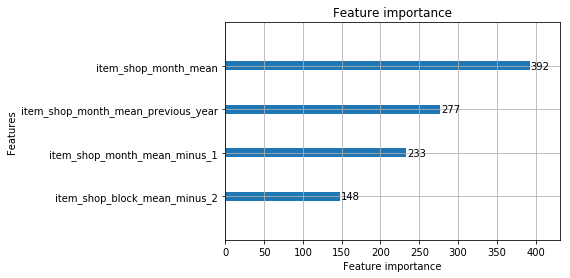

In [364]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit